In [1]:
# %reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"
# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2







/tmp/ipykernel_633981/364510430.py:7: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [41]:
cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.315, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 2.0
sim_params_dict['delta_rhogas'] = 7.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.01
sim_params_dict['log10_Mstar0_theta_co'] = 15.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 2.0
sim_params_dict['log10_Mstar0_theta_ej'] = 15.0
sim_params_dict['nu_theta_ej_M'] = -0.25
sim_params_dict['nu_theta_ej_z'] = 0.5

sim_params_dict['nu_theta_co_c'] = 0.0
sim_params_dict['nu_theta_ej_c'] = 0.0

sim_params_dict['log10_Mc0'] = 15.1
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.1
sim_params_dict['nu_z'] = -5.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 24, 128
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 13.0, 15.5, 32
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 1, 11, 18
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.01
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = False
analysis_dict['calc_nfw_only'] = True





In [42]:
from colossus.cosmology import cosmology
# set cosmology:
cosmology.setCosmology('planck15')
from colossus.halo import concentration

cM13 = concentration.concentration(1E13, '200c', 0.0, model = 'diemer15')
# cM14 = concentration.concentration(1E14, '200c', 0.0, model = 'diemer15')
cM14 = 5.0
cM15 = concentration.concentration(1E15, '200c', 0.0, model = 'diemer15')



In [43]:
# cM14


In [44]:
import copy
import copy
from get_BCMP_profile_jit import BCM_18_wP
from setup_power_spectra_jit import setup_power_BCMP
from tqdm import tqdm
import scipy.integrate as integrate
h = sim_params_dict['cosmo']['H0'] / 100.0
Ob = sim_params_dict['cosmo']['Ob0']
Om = sim_params_dict['cosmo']['Om0']
import astropy.units as u
from astropy import constants as const
import jax_cosmo.background as bkgrd
import scipy.integrate as integrate
from setup_power_spectra_jit import setup_power_BCMP
sigmat = const.sigma_T
m_e = const.m_e
c = const.c
coeff = sigmat / (m_e * (c ** 2))
oneMpc_h_to_cm = (((10 ** 6)/h) * (u.pc).to(u.cm))
const_coeff = ((coeff).to(((u.kpc ** 2) / u.keV))).value





In [45]:
import pandas as pd
# df = pd.read_csv('/mnt/home/spandey/ceph/GODMAX/data/TNG/ForShivam_wY200c.csv')
df = pd.read_csv('/mnt/home/spandey/ceph/GODMAX/data/TNG/ForShivam_Combined.csv')
# df.keys()
Y200c_all = df['Y_200c'].to_numpy() 
# M200c_all = df['M200c'].to_numpy() 
# c200c_all = df['c200c'].to_numpy() 

M200c_all = df['M200c_DMO'].to_numpy() 
c200c_all = df['c200c_DMO'].to_numpy() 



# extract the values from 
# Y200c_all
h = 0.7
indsel1 = np.where((M200c_all > np.log10(9.5e12 * h)) & (M200c_all < np.log10(1.05e13 * h)))[0]
indsel2 = np.where((M200c_all > np.log10(9.0e13 * h)) & (M200c_all < np.log10(1.1e14 * h)))[0]
indsel3 = np.where((M200c_all > np.log10(6.0e14 * h)) & (M200c_all < np.log10(2e15 * h)))[0]


In [52]:
theta_ej_0 = 3.0
nu_theta_ej_M = -0.25

# nu_c_array = [0.0, 0.2, 0.4]
nu_c_array = [-0.25, 0.1, 0.5]
# nu_c_array = [-0.25]






In [53]:
# run for 1e13:
save_Y_all_1e13 = {}
save_Y_YSS_all_1e13 = {}
save_fb_all_1e13 = {}
for jc in range(len(nu_c_array)):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)

    sim_params_dict_vary['theta_ej_0'] = theta_ej_0 * (cM13)**(nu_c_array[jc])
    sim_params_dict_vary['nu_theta_co_c'] = nu_c_array[jc]
    sim_params_dict_vary['nu_theta_ej_c'] = nu_c_array[jc] 
    sim_params_dict_vary['nu_theta_ej_M'] = nu_theta_ej_M

    halo_params_dict_vary = copy.deepcopy(halo_params_dict)
    halo_params_dict_vary['lg10_Mmin'], halo_params_dict_vary['lg10_Mmax'], halo_params_dict_vary['nM'] = 12.0, 15.5, 32

    BCMP_test = BCM_18_wP(sim_params_dict_vary, halo_params_dict_vary)

    z_test = 0.0   
    z_array = BCMP_test.z_array   
    scale_fac_a_array = 1./(1. + z_array)
    indz = np.argmin(np.abs(z_array - z_test))

    M_array = BCMP_test.M_array
    c_array = BCMP_test.conc_array 
    fb_fbSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_YSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_sel = np.zeros((len(M_array), len(c_array)))    

    for indM in range(len(M_array)):

        for indc in range(len(c_array)):

            r200c_Mz = BCMP_test.r200c_mat[indM, indz]

            log_r_array = np.linspace(np.log(0.05*r200c_Mz), np.log(r200c_Mz), 100)

            # indsel_r = np.where(BCMP_test.r_array < r200c_Mz)[0]
            # r_array_j = BCMP_test.r_array[indsel_r]
            r_array_j = np.exp(log_r_array)

            # rho_cga_j = BCMP_test.rho_cga_mat[:,indc, indz, indM]
            # rho_clm_j = BCMP_test.rho_clm_mat[:,indc, indz, indM]
            # rho_gas_j = BCMP_test.rho_gas_mat[:,indc, indz, indM]
            # rho_dmb_j = BCMP_test.rho_dmb_mat[:,indc, indz, indM]
            # rho_nfw_j = BCMP_test.rho_nfw_mat[:,indc, indz, indM]
            Pe_mat_j = BCMP_test.Pe_mat_physical[:,indc, indz, indM]

            # interpolate all into log_r_array:
            # rho_cga_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_cga_j, left=0.0, right=0.0)
            # rho_clm_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_clm_j, left=0.0, right=0.0)
            # rho_gas_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_gas_j, left=0.0, right=0.0)
            # rho_dmb_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_dmb_j, left=0.0, right=0.0)
            # rho_nfw_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_nfw_j, left=0.0, right=0.0)
            Pe_mat_j = np.exp(np.interp(log_r_array, np.log(BCMP_test.r_array), np.log(Pe_mat_j), left=0.0, right=0.0))

            # Mcga_int_j = integrate.simps(4 * np.pi * rho_cga_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mclm_int_j = integrate.simps(4 * np.pi * rho_clm_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mgas_int_j = integrate.simps(4 * np.pi * rho_gas_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mdmb_int_j = integrate.simps(4 * np.pi * rho_dmb_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mnfw_int_j = integrate.simps(4 * np.pi * rho_nfw_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Pe_int_j = integrate.simps(4 * np.pi * Pe_mat_j * r_array_j**2 * r_array_j, np.log(r_array_j)) * (oneMpc_h_to_cm**3)
            Y_int_j = const_coeff * Pe_int_j

            Ez = np.sqrt(bkgrd.growth_factor(BCMP_test.cosmo_jax, scale_fac_a_array))[indz]
            M200_noh = M_array[indM]/h
            h70 = h/0.7
            Y_ss = 97.6 * (1/h70) * (Ez**(2/3.)) * (M200_noh/(1e15/h70))**(5/3.) * (Ob/0.043) * (0.25/Om)
            # fb_ss = Ob/Om

            # fcga = BCMP_test.fcga_array[indM]
            # fstar = BCMP_test.fstar_array[indM]
            # fsga = fstar - fcga
            # fclm = BCMP_test.fclm_array[indM]

            # fgas_ltr200 = Mgas_int_j/Mdmb_int_j
            # fsga_ltr200 = (fsga/fclm) * (Mclm_int_j/Mdmb_int_j)
            # fcga_ltr200 = Mcga_int_j/Mdmb_int_j

            # fb_ltr200 = fgas_ltr200 + fsga_ltr200 + fcga_ltr200
            # fb_fbSS_sel[indM, indc] = fb_ltr200/fb_ss
            Y_YSS_sel[indM, indc] = Y_int_j/Y_ss
            Y_sel[indM, indc] = Y_int_j

    save_Y_all_1e13[jc] = Y_sel    
    save_Y_YSS_all_1e13[jc] = Y_YSS_sel
    # save_fb_all_1e15[jc] = fb_fbSS_sel









In [48]:
# params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'nu_theta_ej_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt', 'nu_theta_ej_M']
# w_init = []
# for jp in range(len(params_vary_names)):
#     w_init.append(sim_params_dict_vary[params_vary_names[jp]])
# w_init = jnp.array(w_init)
# print(w_init)



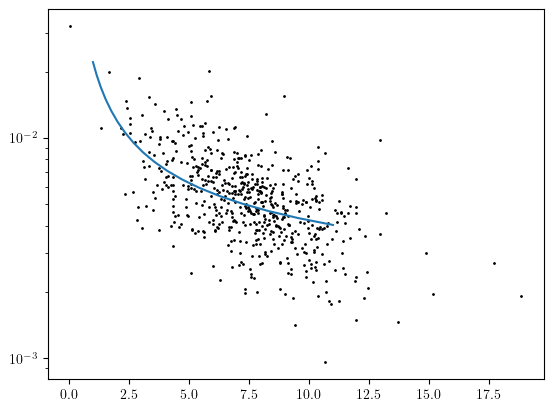

In [54]:
pl.figure()
# for jsim in range(len(theta_ej_array)):
jsim = 0
Y_YSS_sel = save_Y_all_1e13[jsim]
# fb_fbSS_sel = save_fb_all_0p1[jsim]
indM_13 = np.argmin(np.abs(M_array - 1e13))
pl.plot((c_array), (Y_YSS_sel[indM_13,:]), label=r'$c = $' + str(np.round(c_array[2], 2)))
# indM_14 = np.argmin(np.abs(M_array - 1e14))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), label=r'$c = $' + str(np.round(c_array[8], 2)))
# indM_15 = np.argmin(np.abs(M_array - 1e15))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), label=r'$c = $' + str(np.round(c_array[15], 2)))

# jsim = 1
# Y_YSS_sel = save_Y_all_1e13[jsim]
# indM_13 = np.argmin(np.abs(M_array - 1e13))
# pl.plot((c_array), (Y_YSS_sel[indM_13,:]), ls='--', label=r'$c = $' + str(np.round(c_array[2], 2)))

# jsim = 2
# Y_YSS_sel = save_Y_all_1e13[jsim]
# indM_13 = np.argmin(np.abs(M_array - 1e13))
# pl.plot((c_array), (Y_YSS_sel[indM_13,:]), ls=':', label=r'$c = $' + str(np.round(c_array[2], 2)))

pl.scatter((c200c_all[indsel1]), 1e6*(Y200c_all[indsel1]), s=1.0, color='k')

pl.yscale('log')






In [55]:
# run for 1e13:
# theta_ej_0 = 2.0
# nu_c_array = [0.0, 0.2, 0.4]
save_Y_all_1e14 = {}
save_Y_YSS_all_1e14 = {}
save_fb_all_1e14 = {}
for jc in range(len(nu_c_array)):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)

    sim_params_dict_vary['theta_ej_0'] = theta_ej_0 * (cM14)**(nu_c_array[jc])
    sim_params_dict_vary['nu_theta_co_c'] = nu_c_array[jc]
    sim_params_dict_vary['nu_theta_ej_c'] = nu_c_array[jc] 
    sim_params_dict_vary['nu_theta_ej_M'] = nu_theta_ej_M

    halo_params_dict_vary = copy.deepcopy(halo_params_dict)
    halo_params_dict_vary['lg10_Mmin'], halo_params_dict_vary['lg10_Mmax'], halo_params_dict_vary['nM'] = 12.0, 15.5, 32

    BCMP_test = BCM_18_wP(sim_params_dict_vary, halo_params_dict_vary)

    z_test = 0.0   
    z_array = BCMP_test.z_array   
    scale_fac_a_array = 1./(1. + z_array)
    indz = np.argmin(np.abs(z_array - z_test))

    M_array = BCMP_test.M_array
    c_array = BCMP_test.conc_array 
    fb_fbSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_YSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_sel = np.zeros((len(M_array), len(c_array)))    

    for indM in range(len(M_array)):
        for indc in range(len(c_array)):

            r200c_Mz = BCMP_test.r200c_mat[indM, indz]

            log_r_array = np.linspace(np.log(0.05*r200c_Mz), np.log(r200c_Mz), 100)

            # indsel_r = np.where(BCMP_test.r_array < r200c_Mz)[0]
            # r_array_j = BCMP_test.r_array[indsel_r]
            r_array_j = np.exp(log_r_array)

            # rho_cga_j = BCMP_test.rho_cga_mat[:,indc, indz, indM]
            # rho_clm_j = BCMP_test.rho_clm_mat[:,indc, indz, indM]
            # rho_gas_j = BCMP_test.rho_gas_mat[:,indc, indz, indM]
            # rho_dmb_j = BCMP_test.rho_dmb_mat[:,indc, indz, indM]
            # rho_nfw_j = BCMP_test.rho_nfw_mat[:,indc, indz, indM]
            Pe_mat_j = BCMP_test.Pe_mat_physical[:,indc, indz, indM]

            # interpolate all into log_r_array:
            # rho_cga_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_cga_j, left=0.0, right=0.0)
            # rho_clm_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_clm_j, left=0.0, right=0.0)
            # rho_gas_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_gas_j, left=0.0, right=0.0)
            # rho_dmb_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_dmb_j, left=0.0, right=0.0)
            # rho_nfw_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_nfw_j, left=0.0, right=0.0)
            Pe_mat_j = np.exp(np.interp(log_r_array, np.log(BCMP_test.r_array), np.log(Pe_mat_j), left=0.0, right=0.0))

            # Mcga_int_j = integrate.simps(4 * np.pi * rho_cga_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mclm_int_j = integrate.simps(4 * np.pi * rho_clm_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mgas_int_j = integrate.simps(4 * np.pi * rho_gas_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mdmb_int_j = integrate.simps(4 * np.pi * rho_dmb_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mnfw_int_j = integrate.simps(4 * np.pi * rho_nfw_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Pe_int_j = integrate.simps(4 * np.pi * Pe_mat_j * r_array_j**2 * r_array_j, np.log(r_array_j)) * (oneMpc_h_to_cm**3)
            Y_int_j = const_coeff * Pe_int_j

            Ez = np.sqrt(bkgrd.growth_factor(BCMP_test.cosmo_jax, scale_fac_a_array))[indz]
            M200_noh = M_array[indM]/h
            h70 = h/0.7
            Y_ss = 97.6 * (1/h70) * (Ez**(2/3.)) * (M200_noh/(1e15/h70))**(5/3.) * (Ob/0.043) * (0.25/Om)
            # fb_ss = Ob/Om

            # fcga = BCMP_test.fcga_array[indM]
            # fstar = BCMP_test.fstar_array[indM]
            # fsga = fstar - fcga
            # fclm = BCMP_test.fclm_array[indM]

            # fgas_ltr200 = Mgas_int_j/Mdmb_int_j
            # fsga_ltr200 = (fsga/fclm) * (Mclm_int_j/Mdmb_int_j)
            # fcga_ltr200 = Mcga_int_j/Mdmb_int_j

            # fb_ltr200 = fgas_ltr200 + fsga_ltr200 + fcga_ltr200
            # fb_fbSS_sel[indM, indc] = fb_ltr200/fb_ss
            Y_YSS_sel[indM, indc] = Y_int_j/Y_ss
            Y_sel[indM, indc] = Y_int_j

    save_Y_all_1e14[jc] = Y_sel    
    save_Y_YSS_all_1e14[jc] = Y_YSS_sel
    # save_fb_all_1e15[jc] = fb_fbSS_sel









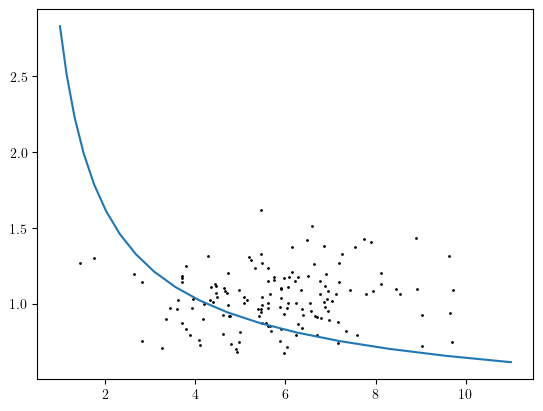

In [56]:
pl.figure()
# for jsim in range(len(theta_ej_array)):
jsim = 0
Y_YSS_sel = save_Y_all_1e14[jsim]
indM_14 = np.argmin(np.abs(M_array - 1e14))
pl.plot((c_array), (Y_YSS_sel[indM_14,:]), label=r'$c = $' + str(np.round(c_array[8], 2)))

# jsim = 1
# Y_YSS_sel = save_Y_all_1e14[jsim]
# indM_14 = np.argmin(np.abs(M_array - 1e14))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), ls='--', label=r'$c = $' + str(np.round(c_array[8], 2)))

# jsim = 2
# Y_YSS_sel = save_Y_all_1e14[jsim]
# indM_14 = np.argmin(np.abs(M_array - 1e14))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), ls=':', label=r'$c = $' + str(np.round(c_array[8], 2)))


pl.scatter((c200c_all[indsel2]), 1e6*(Y200c_all[indsel2]), s=1.0, color='k')







In [57]:
indM_14


18

In [58]:
# run for 1e13:
# theta_ej_0 = 2.0
# nu_c_array = [0.0, 0.2, 0.4]
save_Y_all_1e15 = {}
save_Y_YSS_all_1e15 = {}
save_fb_all_1e15 = {}
for jc in range(len(nu_c_array)):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)

    sim_params_dict_vary['theta_ej_0'] = theta_ej_0 * (cM15)**(nu_c_array[jc])
    sim_params_dict_vary['nu_theta_co_c'] = nu_c_array[jc]
    sim_params_dict_vary['nu_theta_ej_c'] = nu_c_array[jc] 
    sim_params_dict_vary['nu_theta_ej_M'] = nu_theta_ej_M

    halo_params_dict_vary = copy.deepcopy(halo_params_dict)
    halo_params_dict_vary['lg10_Mmin'], halo_params_dict_vary['lg10_Mmax'], halo_params_dict_vary['nM'] = 12.0, 15.5, 32

    BCMP_test = BCM_18_wP(sim_params_dict_vary, halo_params_dict_vary)

    z_test = 0.0   
    z_array = BCMP_test.z_array   
    scale_fac_a_array = 1./(1. + z_array)
    indz = np.argmin(np.abs(z_array - z_test))

    M_array = BCMP_test.M_array
    c_array = BCMP_test.conc_array 
    fb_fbSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_YSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_sel = np.zeros((len(M_array), len(c_array)))    

    for indM in range(len(M_array)):

        for indc in range(len(c_array)):

            r200c_Mz = BCMP_test.r200c_mat[indM, indz]

            log_r_array = np.linspace(np.log(0.05*r200c_Mz), np.log(r200c_Mz), 100)

            # indsel_r = np.where(BCMP_test.r_array < r200c_Mz)[0]
            # r_array_j = BCMP_test.r_array[indsel_r]
            r_array_j = np.exp(log_r_array)

            # rho_cga_j = BCMP_test.rho_cga_mat[:,indc, indz, indM]
            # rho_clm_j = BCMP_test.rho_clm_mat[:,indc, indz, indM]
            # rho_gas_j = BCMP_test.rho_gas_mat[:,indc, indz, indM]
            # rho_dmb_j = BCMP_test.rho_dmb_mat[:,indc, indz, indM]
            # rho_nfw_j = BCMP_test.rho_nfw_mat[:,indc, indz, indM]
            Pe_mat_j = BCMP_test.Pe_mat_physical[:,indc, indz, indM]

            # interpolate all into log_r_array:
            # rho_cga_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_cga_j, left=0.0, right=0.0)
            # rho_clm_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_clm_j, left=0.0, right=0.0)
            # rho_gas_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_gas_j, left=0.0, right=0.0)
            # rho_dmb_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_dmb_j, left=0.0, right=0.0)
            # rho_nfw_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_nfw_j, left=0.0, right=0.0)
            Pe_mat_j = np.exp(np.interp(log_r_array, np.log(BCMP_test.r_array), np.log(Pe_mat_j), left=0.0, right=0.0))

            # Mcga_int_j = integrate.simps(4 * np.pi * rho_cga_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mclm_int_j = integrate.simps(4 * np.pi * rho_clm_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mgas_int_j = integrate.simps(4 * np.pi * rho_gas_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mdmb_int_j = integrate.simps(4 * np.pi * rho_dmb_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            # Mnfw_int_j = integrate.simps(4 * np.pi * rho_nfw_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Pe_int_j = integrate.simps(4 * np.pi * Pe_mat_j * r_array_j**2 * r_array_j, np.log(r_array_j)) * (oneMpc_h_to_cm**3)
            Y_int_j = const_coeff * Pe_int_j

            Ez = np.sqrt(bkgrd.growth_factor(BCMP_test.cosmo_jax, scale_fac_a_array))[indz]
            M200_noh = M_array[indM]/h
            h70 = h/0.7
            Y_ss = 97.6 * (1/h70) * (Ez**(2/3.)) * (M200_noh/(1e15/h70))**(5/3.) * (Ob/0.043) * (0.25/Om)
            # fb_ss = Ob/Om

            # fcga = BCMP_test.fcga_array[indM]
            # fstar = BCMP_test.fstar_array[indM]
            # fsga = fstar - fcga
            # fclm = BCMP_test.fclm_array[indM]

            # fgas_ltr200 = Mgas_int_j/Mdmb_int_j
            # fsga_ltr200 = (fsga/fclm) * (Mclm_int_j/Mdmb_int_j)
            # fcga_ltr200 = Mcga_int_j/Mdmb_int_j

            # fb_ltr200 = fgas_ltr200 + fsga_ltr200 + fcga_ltr200
            # fb_fbSS_sel[indM, indc] = fb_ltr200/fb_ss
            Y_YSS_sel[indM, indc] = Y_int_j/Y_ss
            Y_sel[indM, indc] = Y_int_j

    save_Y_all_1e15[jc] = Y_sel    
    save_Y_YSS_all_1e15[jc] = Y_YSS_sel
    # save_fb_all_1e15[jc] = fb_fbSS_sel









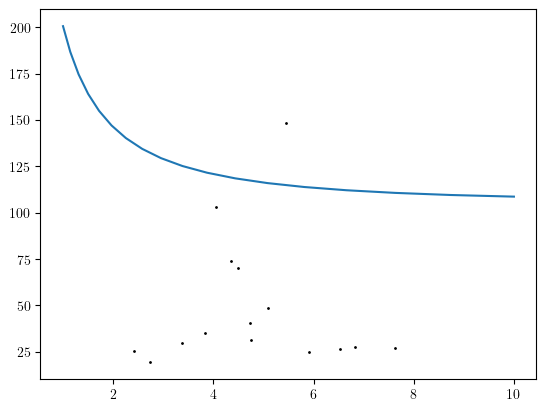

In [17]:
pl.figure()
# for jsim in range(len(theta_ej_array)):
jsim = 0
Y_YSS_sel = save_Y_all_1e15[jsim]
indM_15 = np.argmin(np.abs(M_array - 1e15))
pl.plot((c_array), (Y_YSS_sel[indM_15,:]), label=r'$c = $' + str(np.round(c_array[15], 2)))

# jsim = 1
# Y_YSS_sel = save_Y_all_1e15[jsim]
# indM_15 = np.argmin(np.abs(M_array - 1e15))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), ls='--', label=r'$c = $' + str(np.round(c_array[15], 2)))

# jsim = 2
# Y_YSS_sel = save_Y_all_1e15[jsim]
# indM_15 = np.argmin(np.abs(M_array - 1e15))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), ls=':', label=r'$c = $' + str(np.round(c_array[15], 2)))


pl.scatter((c200c_all[indsel3]), 1e6*(Y200c_all[indsel3]), s=1.0, color='k')




In [40]:
# import pandas as pd
# df = pd.read_csv('/mnt/home/spandey/ceph/GODMAX/data/TNG/ForShivam_wY200c.csv')
# # df.keys()
# Y200c_all = df['Y_200c'].to_numpy() 
# M200c_all = df['M200c'].to_numpy() 
# c200c_all = df['c200c'].to_numpy() 


# # extract the values from 
# # Y200c_all
# h = 0.7
# indsel1 = np.where((M200c_all > np.log10(9.5e12 * h)) & (M200c_all < np.log10(1.05e13 * h)))[0]
# indsel2 = np.where((M200c_all > np.log10(9.0e13 * h)) & (M200c_all < np.log10(1.1e14 * h)))[0]
# indsel3 = np.where((M200c_all > np.log10(6.0e14 * h)) & (M200c_all < np.log10(2e15 * h)))[0]


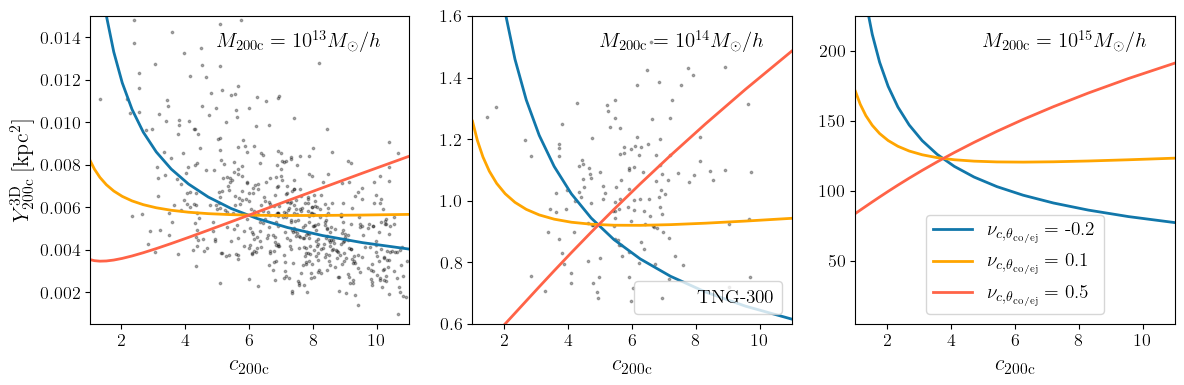

In [74]:
# make a three panel figure with all of above three plots:
fig, ax = pl.subplots(1, 3, figsize=(14, 4))
jsim = 0
Y_YSS_sel = save_Y_all_1e13[jsim]
indM_13 = np.argmin(np.abs(M_array - 1e13))
ax[0].plot((c_array), (Y_YSS_sel[indM_13,:]), color='#1177AA',lw=2.0,label=r'$\eta_{\rm ej/co} = $' + str(np.round(nu_c_array[jsim], 2)))
jsim = 1
Y_YSS_sel = save_Y_all_1e13[jsim]
indM_13 = np.argmin(np.abs(M_array - 1e13))
ax[0].plot((c_array), (Y_YSS_sel[indM_13,:]), color='orange',ls='-',lw=2.0, label=r'$\eta_{\rm ej/co} = $' + str(np.round(nu_c_array[jsim], 2)))
jsim = 2
Y_YSS_sel = save_Y_all_1e13[jsim]
indM_13 = np.argmin(np.abs(M_array - 1e13))
ax[0].plot((c_array), (Y_YSS_sel[indM_13,:]), color='tomato',ls='-',lw=2.0, label=r'$\eta_{\rm ej/co} = $' + str(np.round(nu_c_array[jsim], 2)))

ax[0].scatter((c200c_all[indsel1]), 1e6*(Y200c_all[indsel1]), s=3.0, color='k', alpha=0.3, marker='o', label=r'TNG-300')

ax[0].set_xlabel(r'$c_{\rm 200c}$', fontsize=16)
ax[0].set_ylabel(r'$Y^{\rm 3D}_{\rm 200c}$ [kpc$^2$]', fontsize=16)
# ax[0].set_xlim(5.2, 7.8)
ax[0].set_xlim(1.0, 11.0)
# change tick label sizes:
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].tick_params(axis='both', which='minor', labelsize=13)
# add text about the halo mass:
ax[0].text(0.4, 0.9, r'$M_{\rm 200c} = 10^{13} M_{\odot}/h$', fontsize=15, transform=ax[0].transAxes)
# ax[0].legend(loc='best', fontsize=14)
# ax[0].set_ylim(0.038, 0.045)
ax[0].set_ylim(0.0005, 0.015)
jsim = 0
Y_YSS_sel = save_Y_all_1e14[jsim]
indM_14 = np.argmin(np.abs(M_array - 1e14))
ax[1].plot((c_array), (Y_YSS_sel[indM_14,:]), color='#1177AA',lw=2.0)
jsim = 1
Y_YSS_sel = save_Y_all_1e14[jsim]
ax[1].plot((c_array), (Y_YSS_sel[indM_14,:]), color='orange', ls='-', lw=2.0)
jsim = 2
Y_YSS_sel = save_Y_all_1e14[jsim]
ax[1].plot((c_array), (Y_YSS_sel[indM_14,:]), color='tomato',ls='-', lw=2.0)


ax[1].scatter((c200c_all[indsel2]), 1e6*(Y200c_all[indsel2]), s=3.0, color='k', alpha=0.3, marker='o', label=r'TNG-300')
ax[1].legend(loc='lower right', fontsize=14, ncol=1)

ax[1].set_xlabel(r'$c_{\rm 200c}$', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].tick_params(axis='both', which='minor', labelsize=13)
ax[1].text(0.4, 0.9, r'$M_{\rm 200c} = 10^{14} M_{\odot}/h$', fontsize=15, transform=ax[1].transAxes)
ax[1].set_xlim(1.0, 11.0)
ax[1].set_ylim(0.6, 1.6)
jsim = 0
Y_YSS_sel = save_Y_all_1e15[jsim]
indM_15 = np.argmin(np.abs(M_array - 1e15))
ax[2].plot((c_array), (Y_YSS_sel[indM_15,:]), color='#1177AA',lw=2.0,label=r'$\nu_{c, \theta_{\rm co/ej}} = $ ' + str(np.round(nu_c_array[jsim], 1)))
jsim = 1
Y_YSS_sel = save_Y_all_1e15[jsim]
ax[2].plot((c_array), (Y_YSS_sel[indM_15,:]), color='orange', lw=2.0, ls='-', label=r'$\nu_{c, \theta_{\rm co/ej}} = $ ' + str(np.round(nu_c_array[jsim], 1)))
jsim = 2
Y_YSS_sel = save_Y_all_1e15[jsim]
ax[2].plot((c_array), (Y_YSS_sel[indM_15,:]), color='tomato', lw=2.0,ls='-', label=r'$\nu_{c, \theta_{\rm co/ej}} = $ ' + str(np.round(nu_c_array[jsim], 1)))

# ax[2].scatter((c200c_all[indsel3]),     1e6*(Y200c_all[indsel3]), s=5.0, color='k', alpha=0.3, marker='o', label=r'TNG-300')
# ax[2].legend(loc='lower right', fontsize=14, ncol=1)
ax[2].legend(loc='lower center', fontsize=14, ncol=1)

ax[2].set_xlabel(r'$c_{\rm 200c}$', fontsize=16)
ax[2].tick_params(axis='both', which='major', labelsize=13)
ax[2].tick_params(axis='both', which='minor', labelsize=13)
ax[2].text(0.4, 0.9, r'$M_{\rm 200c} = 10^{15} M_{\odot}/h$', fontsize=15, transform=ax[2].transAxes)
ax[2].set_xlim(1.0, 11.0)
ax[2].set_ylim(5, 225)
pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/Yc_vs_c_vary_nu_c_wsims.pdf', bbox_inches='tight')




In [104]:
5*1e6*(Y200c_all[indsel3])

array([741.6144512 , 515.61887211, 369.65516983, 350.72810238,
       251.62817679, 128.14172299, 176.57161759, 243.05034523,
       220.31374881, 190.60788524, 148.89543281, 202.83423719,
       134.26195173, 156.48586928, 138.51317211,  96.99254195,
       132.71860466, 125.55135414])

In [11]:
# extract the values from 
# Y200c_all
h = 0.7
indsel = np.where((M200c_all > np.log10(9.5e12 * h)) & (M200c_all < np.log10(1.05e13 * h)))[0]
# indsel = np.where((M200c_all > np.log10(9.0e13 * h)) & (M200c_all < np.log10(1.1e14 * h)))[0]
# indsel = np.where((M200c_all > np.log10(6.0e14 * h)) & (M200c_all < np.log10(2e15 * h)))[0]


In [12]:
# M200c_all
np.amin(M200c_all[np.isfinite(M200c_all)]), np.amax(M200c_all[np.isfinite(M200c_all)])


(9.871894436172976, 15.179816620871769)

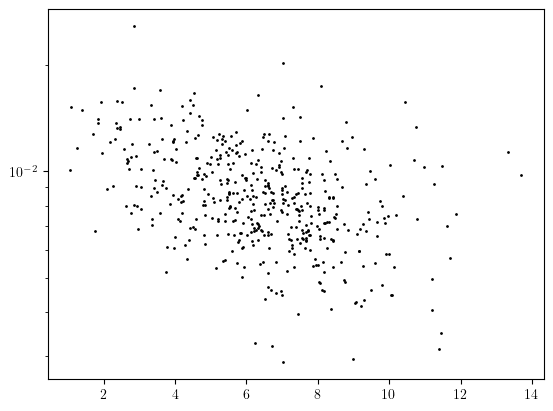

In [13]:
pl.figure()
pl.scatter((c200c_all[indsel]), 1e6*(Y200c_all[indsel]), s=1.0, color='k')
pl.yscale('log')




In [54]:
import h5py as h5
df = h5.File('/mnt/ceph/users/spandey/GODMAX/data/300/CGM-profiles-progenitors_evoz.hdf5', 'r')


In [4]:
list(df.keys())


['NewMDCLUSTER_0001',
 'NewMDCLUSTER_0002',
 'NewMDCLUSTER_0003',
 'NewMDCLUSTER_0004',
 'NewMDCLUSTER_0005',
 'NewMDCLUSTER_0006',
 'NewMDCLUSTER_0007',
 'NewMDCLUSTER_0008',
 'NewMDCLUSTER_0009',
 'NewMDCLUSTER_0010',
 'NewMDCLUSTER_0011',
 'NewMDCLUSTER_0012',
 'NewMDCLUSTER_0013',
 'NewMDCLUSTER_0014',
 'NewMDCLUSTER_0015',
 'NewMDCLUSTER_0016',
 'NewMDCLUSTER_0017',
 'NewMDCLUSTER_0018',
 'NewMDCLUSTER_0019',
 'NewMDCLUSTER_0020',
 'NewMDCLUSTER_0021',
 'NewMDCLUSTER_0022',
 'NewMDCLUSTER_0023',
 'NewMDCLUSTER_0024',
 'NewMDCLUSTER_0025',
 'NewMDCLUSTER_0026',
 'NewMDCLUSTER_0027',
 'NewMDCLUSTER_0028',
 'NewMDCLUSTER_0029',
 'NewMDCLUSTER_0030',
 'NewMDCLUSTER_0031',
 'NewMDCLUSTER_0032',
 'NewMDCLUSTER_0033',
 'NewMDCLUSTER_0034',
 'NewMDCLUSTER_0035',
 'NewMDCLUSTER_0036',
 'NewMDCLUSTER_0037',
 'NewMDCLUSTER_0038',
 'NewMDCLUSTER_0039',
 'NewMDCLUSTER_0040',
 'NewMDCLUSTER_0041',
 'NewMDCLUSTER_0042',
 'NewMDCLUSTER_0043',
 'NewMDCLUSTER_0044',
 'NewMDCLUSTER_0045',
 'NewMDCLU

In [27]:
df['NewMDCLUSTER_0324']['snap_128']['Pressure'][()]


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.35920265e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.33300692e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.68708298e-01, 1.48388387e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.96665295e-01,
       1.04847673e+00, 6.26245124e-01, 3.18642255e-01, 4.68201856e-01,
       2.17863094e-01, 5.49467028e-01, 0.00000000e+00, 5.28320135e-01,
       6.02939326e-01, 5.26680457e-01, 2.58357870e-01, 0.00000000e+00,
      

In [55]:
len(df['README'])

0